In [1]:
import numpy as np
from topagnps2cche1d.crosssection import CrossSection

xs = CrossSection(id=1)

xs.define_trapz_cross_section_width_slope_elevation()

(array([-43., -35., -13., -10.,  10.,  13.,  35.,  43.]),
 array([6, 2, 2, 0, 0, 2, 2, 6]),
 2,
 3,
 4,
 5)

In [3]:
ws, zs, n_rgh = xs.ws, xs.zs, xs.n_rgh

In [13]:
L = []

start_count = 11
num = 3
posidx = list(range(start_count, start_count + num))
print(posidx)

L.extend(range(start_count, start_count + 3))
print(L)

[11, 12, 13]
[11, 12, 13]


In [17]:
from pathlib import Path

root = Path().cwd()
Path(root)

WindowsPath('c:/Users/Luc/projects/topagnps2cche1d/notebooks_and_scripts')

In [15]:
file = root
file

WindowsPath('c:/Users/Luc/projects/topagnps2cche1d/notebooks_and_scripts')

In [16]:
file.with_name(f"{'hello'}_channel.dat")

WindowsPath('c:/Users/Luc/projects/topagnps2cche1d/hello_channel.dat')

In [9]:
S = set()

S.add(1)
S.update([2, 3])

print(S)

for i in S:
    print(i)

{1, 2, 3}
1
2
3


In [1]:
A = {1: "a", 2: "b"}

u = A.pop(1)

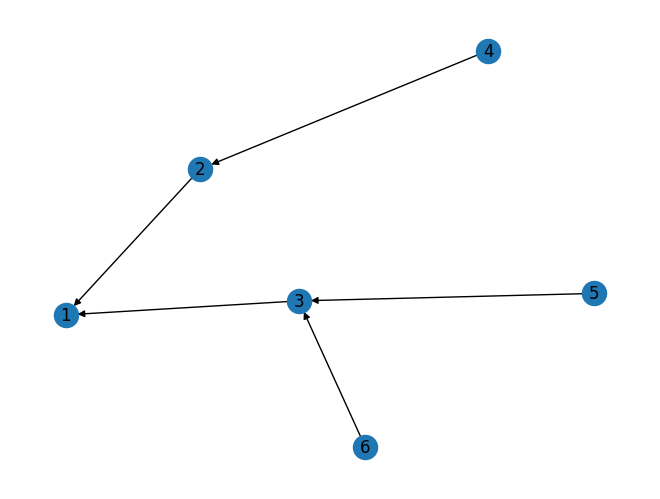

In [4]:
import networkx as nx

G = nx.MultiDiGraph()

G.add_edge(2, 1)
G.add_edge(3, 1)
G.add_edge(4, 2)
G.add_edge(5, 3)
G.add_edge(6, 3)


nx.draw(G, with_labels=True)

In [8]:
list(nx.bfs_tree(G.reverse(), 1))

[1, 2, 3, 4, 5, 6]

In [6]:
from topagnps2cche1d.tools import path_crawler
import numpy as np
import networkx as nx

I = np.array(
    [
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1],
    ]
)

(rows, cols) = np.nonzero(I)

rowcols = [(row, col) for row, col in zip(rows, cols)]

G = path_crawler(rowcols)

extremities = [rowcol for rowcol in G.nodes() if nx.degree(G, rowcol) <= 1]

print(extremities)

In [34]:
def path_crawler_old(rowcols):
    """
    This function takes as input a list of (row, col) coordinates
    forming a linear path and returns the linear path connecting them
    prioritizing North/South/East/West direction over diagonals
    """
    deltas = {
        (-1, 0): "North",
        (0, -1): "West",
        (1, 0): "South",
        (0, 1): "East",
        (-1, -1): "NorthWest",
        (1, -1): "SouthWest",
        (1, 1): "SouthEast",
        (-1, 1): "NorthEast",
    }

    G = nx.Graph()

    rowcols_to_visit = rowcols.copy()
    maxiter = len(rowcols_to_visit)
    orphans = []  # The algorithm will most likely not start by an actual extremity
    # Therefore the path will start at some pixel in between, the algorithm will crawl
    # to one end and then will continue from where it started and finish connecting the path
    # in the other direction

    rowcol = rowcols_to_visit.pop(0)
    start = rowcol

    if not rowcols_to_visit:
        # only one node
        G.add_node(rowcol)

    iter = 0
    while rowcols_to_visit:
        iter += 1
        if iter == maxiter:
            raise Exception(
                "Maximum number of iterations reached! Probably invalid path"
            )

        for counter, delta in enumerate(deltas, 1):
            rowcolnext = (rowcol[0] + delta[0], rowcol[1] + delta[1])

            if rowcolnext in rowcols_to_visit:
                G.add_edge(rowcol, rowcolnext)
                # jump there
                rowcol = rowcolnext
                rowcols_to_visit.remove(rowcolnext)
                break
            elif counter == 8:
                # if all directions have been found and there are still rowcols to visit
                # it means the starting point was not an extremity. Therefore we need to start
                # somewhere else and append the orphans that we'll deal with later
                orphans.append(start)
                rowcol = rowcols_to_visit.pop(0)
                start = rowcol

    # Finish connecting the orphans
    for orphan in orphans:
        for delta in deltas:
            rowcolnext = (orphan[0] + delta[0], orphan[1] + delta[1])
            if rowcolnext in rowcols:
                G.add_edge(orphan, rowcolnext)

    return G

In [37]:
def path_crawler3(rowcols):
    """
    This function takes as input a list of (row, col) coordinates
    and returns a graph representing the longest linear path connecting them
    prioritizing North/South/East/West direction over diagonals
    """
    deltas = {
        (-1, 0): "North",
        (0, -1): "West",
        (1, 0): "South",
        (0, 1): "East",
        (-1, -1): "NorthWest",
        (1, -1): "SouthWest",
        (1, 1): "SouthEast",
        (-1, 1): "NorthEast",
    }
    G = nx.Graph()
    rowcols_set = set(rowcols)

    if len(rowcols_set) == 1:
        G.add_node(rowcols[0])
        return G

    def extend_path(start, path):
        path.append(start)
        while True:
            neighbors = [
                (start[0] + delta[0], start[1] + delta[1])
                for delta in deltas.keys()
                if (start[0] + delta[0], start[1] + delta[1]) in rowcols_set - set(path)
            ]
            if not neighbors:
                break
            next_node = min(neighbors, key=lambda x: deltas.get((x[0] - start[0], x[1] - start[1]), -1))
            G.add_edge(start, next_node)
            start = next_node
            path.append(start)

    longest_path = []
    for rowcol in rowcols_set:
        path = []
        extend_path(rowcol, path)
        if len(path) > len(longest_path):
            longest_path = path

    G.clear()
    for i in range(len(longest_path) - 1):
        G.add_edge(longest_path[i], longest_path[i + 1])

    return G

In [38]:
from topagnps2cche1d.tools import path_crawler
import numpy as np
import networkx as nx

# I = np.array(
#     [
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 1, 0, 0, 0, 0],
#         [0, 1, 0, 1, 1, 1, 0],
#         [0, 1, 0, 0, 0, 0, 1],
#         [0, 0, 1, 0, 0, 0, 0],
#         [0, 0, 1, 0, 0, 0, 0],
#     ]
# )

I = np.array(
    [
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ]
)

(rows, cols) = np.nonzero(I)

rowcols = [(row, col) for row, col in zip(rows, cols)]

G = path_crawler3(rowcols)

extremities = [rowcol for rowcol in G.nodes() if nx.degree(G, rowcol) <= 1]

print(extremities)

[(1, 1)]


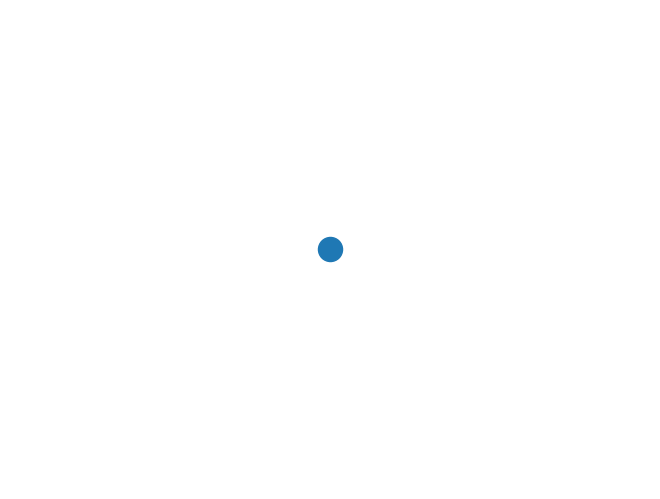

In [36]:
nx.draw(G)

In [3]:
list(nx.dfs_preorder_nodes(G, (0, 0)))

KeyError: (0, 0)